# Mapping wells in the Montney Formation
*March 6, 2022*

We want to create some maps of well locations in the Montney Formation. To do this, we'll spatial join well location data onto a shapefile of the Montney Formation.

Using pandas and geopandas for the analysis, so read them in here.

In [84]:
import pandas as pd
import geopandas

Read in well hole data from B.C.

This data was downloaded from [here](https://data-bcogc.opendata.arcgis.com/datasets/9149cb556e694617970a5774621af8be_0/explore?location=53.951476%2C-122.515550%2C7.00).

In [85]:
raw = geopandas.read_file("bc_wells.zip").to_crs("EPSG:4326")

raw.head(1)

,OBJECTID,WELL_AUTHO,OPERATOR_A,OPERATOR_1,WELL_SURFA,WELL_AREA_,OPTIONAL_W,WELL_NAME_,WELL_NAME,WELL_ACTIV,BORE_FLUID,OPERATION_,STATUS_EFF,WELL_AUT_1,CONFIDENTI,geometry
0,82319162,00001,ROYAL,None,D- 080-H/092-G-03,CITY NO. 1,None,1948-06-10,ROYAL CITY NO. 1 D- 080-H/092-G-03,ABAN,UND,UND,1948-12-11,1948-06-10,N,POINT (-123.11479 49.14810)


Copy the dataframe.

In [86]:
bc_wells = raw.copy()

Now we select only the columns we need going forward.

In [87]:
bc_wells = bc_wells[["OBJECTID", "WELL_ACTIV", "geometry"]]

bc_wells["PROVINCE"] = "BC"

bc_wells.head(5)

,OBJECTID,WELL_ACTIV,geometry,PROVINCE
0,82319162,ABAN,POINT (-123.11479 49.14810),BC
1,82319163,ABAN,POINT (-114.49785 49.03533),BC
2,82319164,ABAN,POINT (-114.55412 49.04789),BC
3,82319165,ABAN,POINT (-120.55446 56.01253),BC
4,82319166,ABAN,POINT (-120.43091 54.88573),BC


Now let's read in the Alberta data. We're using surface hole data here, not the bottom hole file on the same page. [Data source](https://www.aer.ca/providing-information/data-and-reports/statistical-reports/st37)

In [88]:
ab_raw = geopandas.read_file("ab_wells.zip")

ab_raw.head(3)

,Licence,CompName,Latitude,Longitude,KBE,GroundElev,SurfLoc,EDCT,RatingLev,LicStatus,LicStatDat,OpSurvProv,geometry
0,0000001,BP Canada Energy Group ULC(A62D),53.386619,-113.617905,700.4,697.4,08-09-051-25W4,BWL,J,RecExempt,05 Jul 1949,None,MULTIPOINT (-113.61790 53.38662)
1,0000002,Canadian Turbo Inc.(0M69),53.256289,-113.680744,724.5,719.0,05-25-049-26W4,BWL,J,RecExempt,12 Aug 1949,None,MULTIPOINT (-113.68074 53.25629)
2,0000003,BP Canada Energy Group ULC(A62D),54.346682,-113.334918,687.6,683.7,07-11-062-23W4,BWL,J,RecExempt,21 Jul 1949,None,MULTIPOINT (-113.33492 54.34668)


Filter for the same columns as B.C. and rename to match B.C. columns. We also add the same province column in case we want to separate them at some point.

In [89]:
ab_wells = ab_raw[["Licence", "LicStatus", "geometry"]]

ab_wells.columns = ["OBJECTID", "WELL_ACTIV", "geometry"]

ab_wells["PROVINCE"] = "AB"

ab_wells

c:\Users\dexmc\anaconda3\envs\geo\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,OBJECTID,WELL_ACTIV,geometry,PROVINCE
0,0000001,RecExempt,MULTIPOINT (-113.61790 53.38662),AB
1,0000002,RecExempt,MULTIPOINT (-113.68074 53.25629),AB
2,0000003,RecExempt,MULTIPOINT (-113.33492 54.34668),AB
3,0000006,Abandoned,MULTIPOINT (-113.77833 53.37612),AB
4,0000007,Suspension,MULTIPOINT (-113.05958 53.93988),AB
...,...,...,...,...
502652,Y0003293,RecExempt,MULTIPOINT (-111.58978 57.26246),AB
502653,Y0003294,RecExempt,MULTIPOINT (-111.59820 57.49372),AB
502654,Y0003295,RecExempt,MULTIPOINT (-111.59058 57.49373),AB
502655,Z0000001,RecCertified,MULTIPOINT (-111.17259 56.39635),AB


Now we put both our provinces together into one dataset.

In [90]:
all_wells = pd.concat([bc_wells, ab_wells])

all_wells

,OBJECTID,WELL_ACTIV,geometry,PROVINCE
0,82319162,ABAN,POINT (-123.11479 49.14810),BC
1,82319163,ABAN,POINT (-114.49785 49.03533),BC
2,82319164,ABAN,POINT (-114.55412 49.04789),BC
3,82319165,ABAN,POINT (-120.55446 56.01253),BC
4,82319166,ABAN,POINT (-120.43091 54.88573),BC
...,...,...,...,...
502652,Y0003293,RecExempt,MULTIPOINT (-111.58978 57.26246),AB
502653,Y0003294,RecExempt,MULTIPOINT (-111.59820 57.49372),AB
502654,Y0003295,RecExempt,MULTIPOINT (-111.59058 57.49373),AB
502655,Z0000001,RecCertified,MULTIPOINT (-111.17259 56.39635),AB


Read in a boundary file for the Montney. This file is split into different shapes that make up the Montney, so we dissolve them together.

In [91]:
boundary = (geopandas.read_file("montney-boundary.zip")
            .to_crs("EPSG:4326")
            .dissolve("MAP_NAME")
            .reset_index()
            )

boundary

,MAP_NAME,geometry,ID,DESCR1
0,Montney Isopach and Lithofacies,"POLYGON ((-116.82320 53.20750, -116.88293 53.2...",744.0,"Facies 2: Siltstone, gray, argillaceous and sl..."


Perform a spatial join so we can get just the wells inside the Montney.

In [92]:
montney_wells = geopandas.sjoin(all_wells, boundary).drop(columns=["index_right", "MAP_NAME", "ID", "DESCR1"]).set_index("OBJECTID")

montney_wells

,WELL_ACTIV,geometry,PROVINCE
OBJECTID,,,
82319165,ABAN,POINT (-120.55446 56.01253),BC
82319168,ABAN,POINT (-120.69240 55.77955),BC
82319206,ABAN,POINT (-120.63107 55.87155),BC
82319207,ABAN,POINT (-120.61746 55.81620),BC
82319208,ABAN,POINT (-120.49039 55.83428),BC
...,...,...,...
X0000420,RecExempt,MULTIPOINT (-119.73010 55.86169),AB
X0000444,RecExempt,MULTIPOINT (-119.91431 55.95559),AB
X0000453,RecExempt,MULTIPOINT (-117.30417 56.24206),AB


Now to classify each status into a broader status column we'll just call "custom". We're interested in the "WELL_ACTIV" column, because that will tell us which wells are active, which are not, and which may become active soon. We'll create a new column to split each status into one of these three categories.

Information about these statuses for B.C. is found [here](https://www.bc-er.ca/files/gis/WELLCODE_METADATA.pdf).
Information for the AB wells is found in the General Well Data File layout guide on [this page](https://www.aer.ca/providing-information/data-and-reports/activity-and-data/product-reference-layouts).

First let's replace B.C. codes with more descriptive versions.

In [93]:
replace = {
    "CASE": "Cased",
    "COMP": "Completed",
    "DRIL": "Drilling",
    "DSUS": "Drilling Suspended",
    "GAST": "Gas Testing",
    "PRES": "Prep to Resume",
    "PSPD": "Prep to Spud",
    "WAG": "Well Auth Granted",
    "ACT": "Active",
    "ABNZ": "Abandoned Zone",
    "CANC": "Cancelled",
    "ABAN": "Abandoned",
    "SUSP": "Suspended"
}

montney_wells["WELL_ACTIV"] = montney_wells["WELL_ACTIV"].replace(replace)

Now we'll define which status belongs in which of our three categories: "active", "soon", and "inactive".

In [94]:
BC_ACTIVE_STATUSES = ["Active"]
BC_SOON_STATUSES = ["Completed", "Cased", "Drilling Suspended", "Gas Testing", "Prep to Resume", "Prep to Spud", "Well Auth Granted"]
BC_INACTIVE_STATUSES = []

AB_ACTIVE_STATUSES = ["Amended", "Issued", "Re-entered"]
AB_SOON_STATUSES = []
AB_INACTIVE_STATUSES = []

Now we make a new column with information that matches our categorizations above.

In [95]:
montney_wells.loc[montney_wells["WELL_ACTIV"].isin(BC_ACTIVE_STATUSES + AB_ACTIVE_STATUSES), "custom"] = "ACTIVE"
montney_wells.loc[montney_wells["WELL_ACTIV"].isin(BC_SOON_STATUSES + AB_SOON_STATUSES), "custom"] = "SOON"

montney_wells["custom"] = montney_wells["custom"].fillna("INACTIVE")

montney_wells.sample(3)

,WELL_ACTIV,geometry,PROVINCE,custom
OBJECTID,,,,
0268655,Issued,MULTIPOINT (-116.97769 53.61195),AB,ACTIVE
0428647,Suspension,MULTIPOINT (-116.66422 54.53528),AB,INACTIVE
82329576,Suspended,POINT (-120.01771 56.51958),BC,INACTIVE


And finally, pivot to see what it looks like for each province.

In [99]:
montney_wells.pivot_table(columns="PROVINCE", index="custom", values="geometry", aggfunc="count").fillna(0)

PROVINCE,AB,BC
custom,,
ACTIVE,24837.0,7982.0
INACTIVE,27557.0,15518.0
SOON,0.0,3174.0


Let's also map it to make sure we didn't totally flub any of the analysis.

<AxesSubplot:>

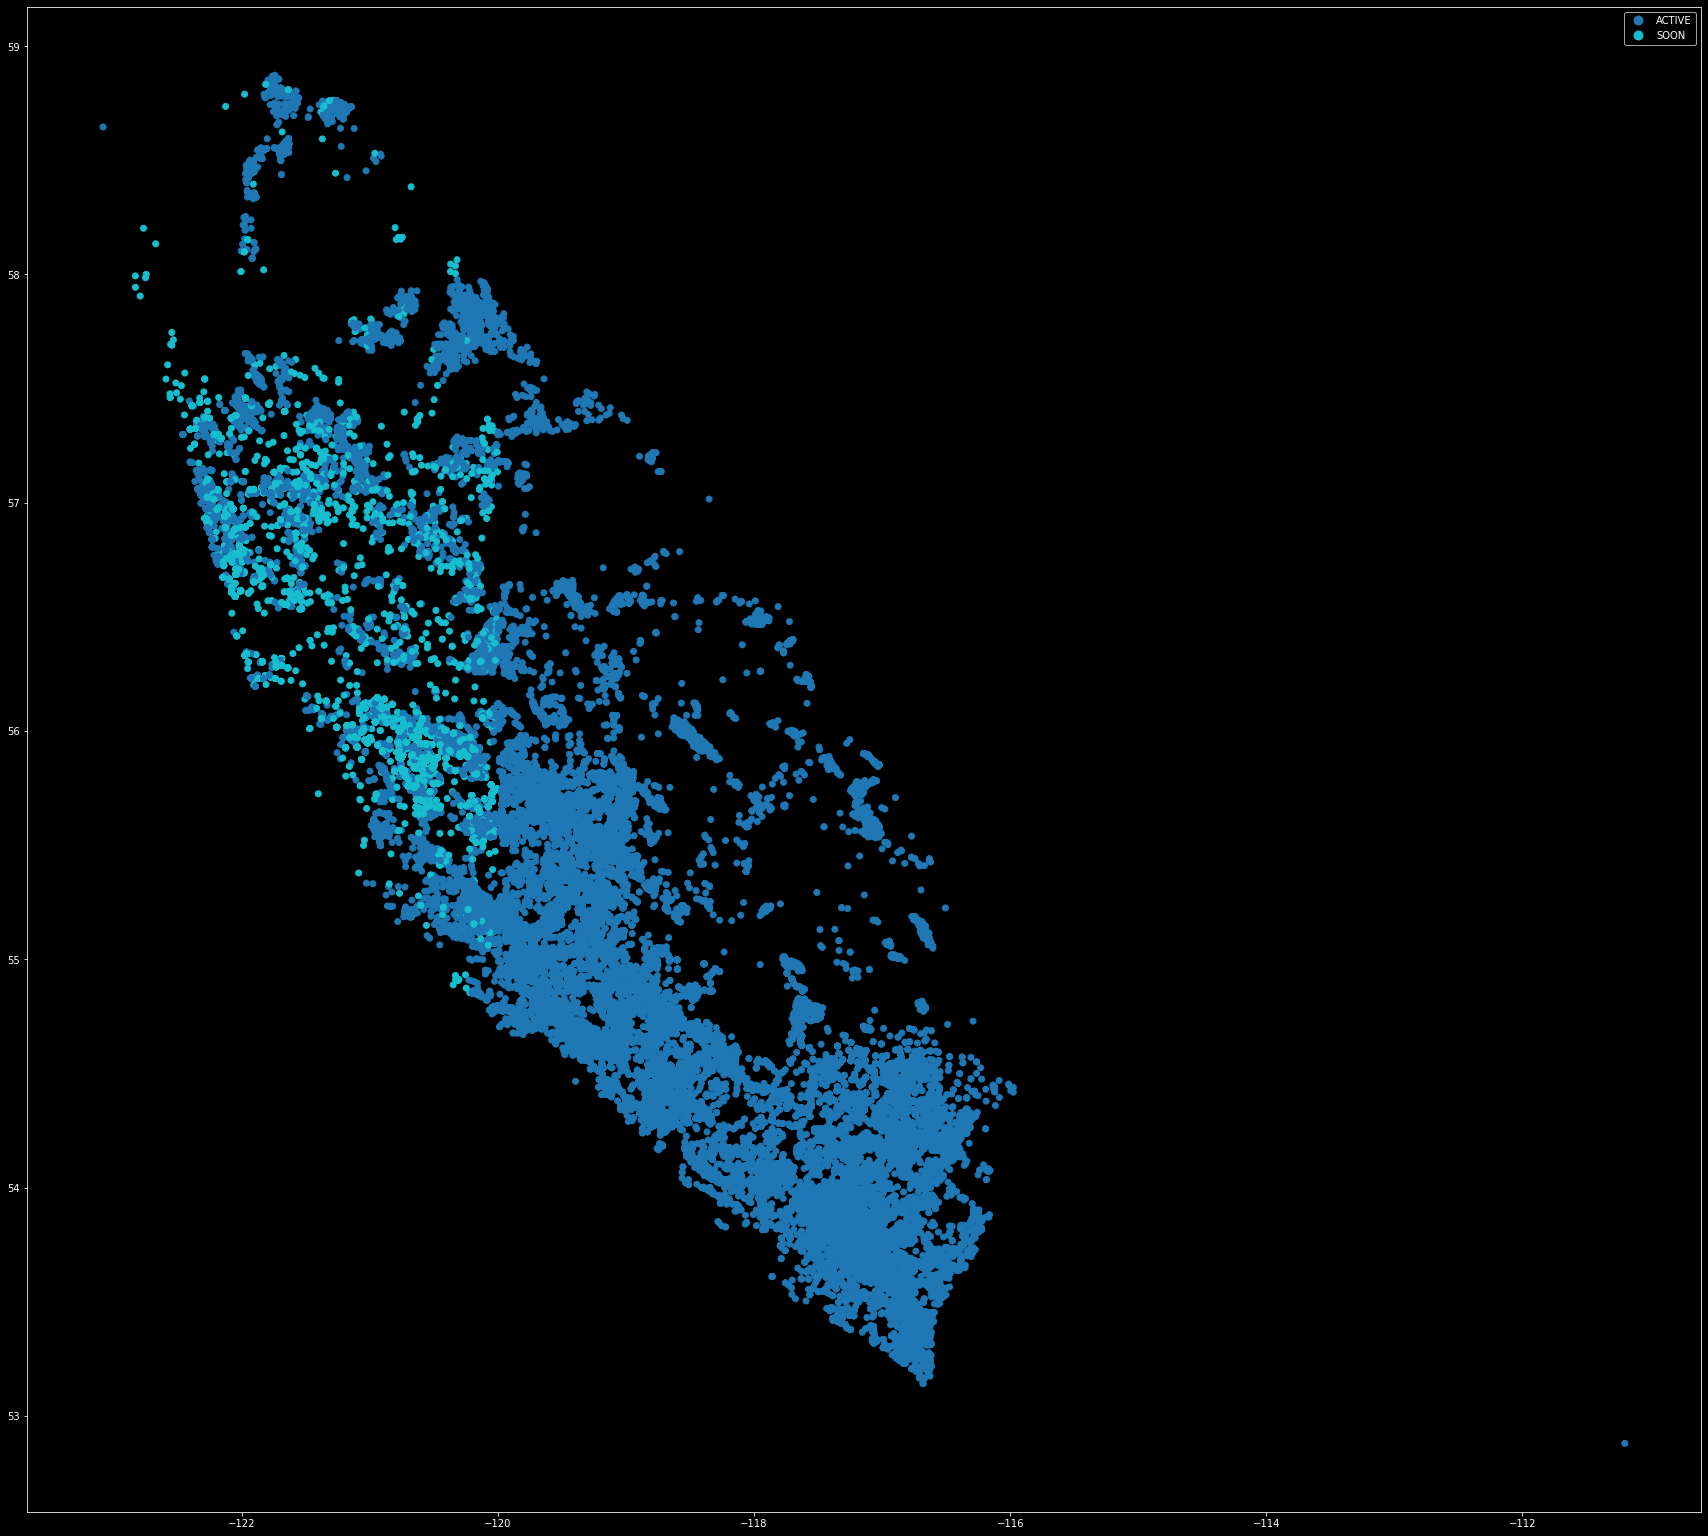

In [101]:
montney_wells[montney_wells["custom"] != "INACTIVE"].plot(figsize=(30, 30), column="custom", legend=True)

Yep, looks like it should!
\-30\-